In [1]:
# Import basci libraries
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the PlantGrowth dataset
from statsmodels.datasets import get_rdataset
my_data = get_rdataset('PlantGrowth').data
my_data = pd.DataFrame(my_data)
sample_data = my_data.sample(n = 10, replace = True)
print(sample_data)

    weight group
7     4.53  ctrl
16    6.03  trt1
28    5.80  trt2
3     6.11  ctrl
29    5.26  trt2
5     4.61  ctrl
7     4.53  ctrl
29    5.26  trt2
29    5.26  trt2
2     5.18  ctrl


In [3]:
# Create a list of unique group levels
group_levels = my_data['group'].unique()
print(group_levels)

['ctrl' 'trt1' 'trt2']


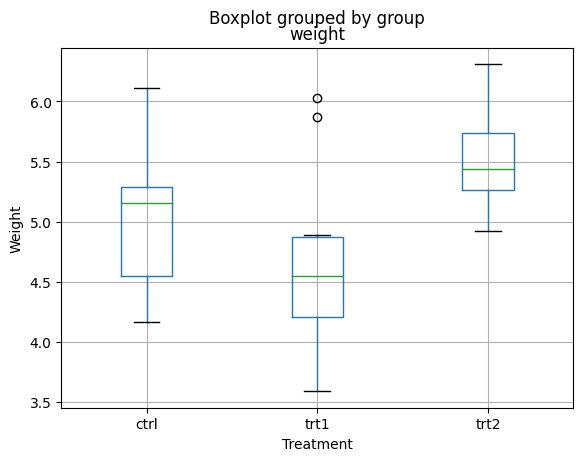

In [4]:
# Create a boxplot of weight by group
my_data.boxplot(column='weight', by='group')
plt.xlabel('Treatment')
plt.ylabel('Weight')
plt.show()

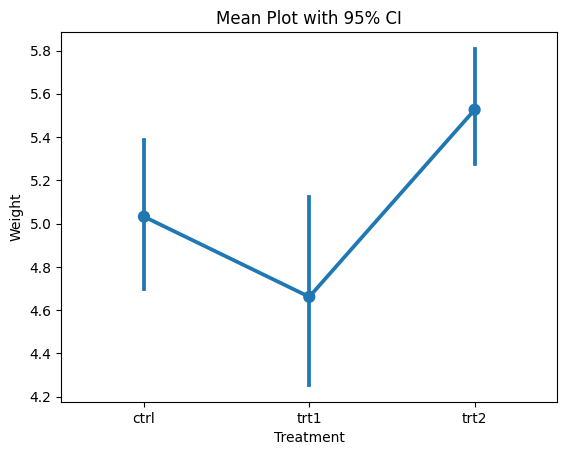

In [5]:
# Create a mean plot with 95% confidence intervals
sns.pointplot(x='group', y='weight', data=my_data, errorbar=('ci', 95))
plt.xlabel('Treatment')
plt.ylabel('Weight')
plt.title('Mean Plot with 95% CI')
plt.show()

In [6]:
#Perform One-way ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('weight ~ group', data=my_data).fit() # Fit the ANOVA model
anova_table = sm.stats.anova_lm(model, typ=2) # Compute the ANOVA table
print(anova_table)

            sum_sq    df         F   PR(>F)
group      3.76634   2.0  4.846088  0.01591
Residual  10.49209  27.0       NaN      NaN


In [7]:
# Perform the Tukey HSD test
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(my_data['weight'], my_data['group'])
tukey_result = mc.tukeyhsd()
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  ctrl   trt1   -0.371 0.3909 -1.0622 0.3202  False
  ctrl   trt2    0.494  0.198 -0.1972 1.1852  False
  trt1   trt2    0.865  0.012  0.1738 1.5562   True
---------------------------------------------------


In [8]:
# Perform pairwise t-tests
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

results = []
for i in range(len(group_levels)):
    for j in range(i+1, len(group_levels)):
        group1 = my_data[my_data['group'] == group_levels[i]]['weight']
        group2 = my_data[my_data['group'] == group_levels[j]]['weight']
        t_stat, p_val = ttest_ind(group1, group2)
        results.append([group_levels[i], group_levels[j], p_val])

# Apply multiple comparison correction
pvals = [result[2] for result in results]
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')

for i, result in enumerate(results): # Print the results
    print(f'{result[0]} vs. {result[1]}: p = {pvals_corrected[i]}')

ctrl vs. trt1: p = 0.2490231659730067
ctrl vs. trt2: p = 0.07027707736736039
trt1 vs. trt2: p = 0.022555278354659574


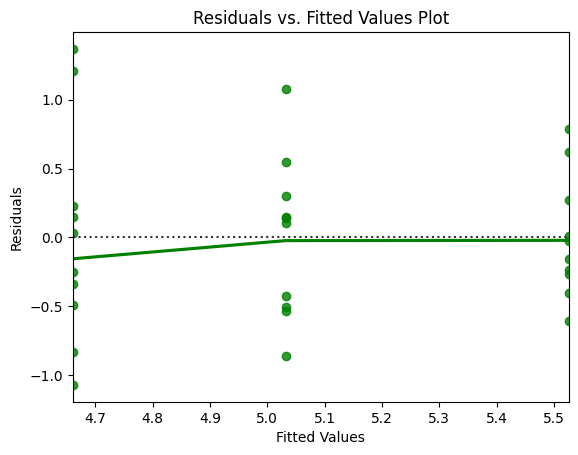

In [9]:
# Extract the residuals and fitted values
residuals = model.resid
fitted_values = model.fittedvalues

# Create a plot of residuals vs. fitted values
sns.residplot(x=fitted_values, y=residuals, lowess=True, color="g")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

In [10]:
# Perform Levene's test for homogeneity of variances
from scipy.stats import levene

stat, pval = levene(my_data[my_data['group'] == 'ctrl']['weight'],
                    my_data[my_data['group'] == 'trt1']['weight'],
                    my_data[my_data['group'] == 'trt2']['weight'])
print(f"Levene's test: F = {stat}, p = {pval}")

Levene's test: F = 1.1191856948703909, p = 0.3412266241254737


In [11]:
# Perform one-way ANOVA test
from scipy.stats import f_oneway

f_stat, pval = f_oneway(my_data[my_data['group'] == 'ctrl']['weight'],
                        my_data[my_data['group'] == 'trt1']['weight'],
                        my_data[my_data['group'] == 'trt2']['weight'])
print(f"One-way ANOVA: F = {f_stat}, p = {pval}")

One-way ANOVA: F = 4.846087862380136, p = 0.0159099583256229


In [12]:
# Perform pairwise t-tests with BH correction
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

results = []
for i, group1 in enumerate(['ctrl', 'trt1', 'trt2']):
    for j, group2 in enumerate(['ctrl', 'trt1', 'trt2']):
        if j > i:
            t_stat, p_val = ttest_ind(my_data[my_data['group'] == group1]['weight'],
                                      my_data[my_data['group'] == group2]['weight'],
                                      equal_var=False)
            results.append([group1, group2, p_val])

pvals = [result[2] for result in results]
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')

for i, result in enumerate(results):
    print(f"{result[0]} vs. {result[1]}: p = {pvals_corrected[i]}")

ctrl vs. trt1: p = 0.25038250858754874
ctrl vs. trt2: p = 0.07184888340295344
trt1 vs. trt2: p = 0.02789521415180952


Shapiro-Wilk test: W = 0.9660681486129761, p = 0.43789875507354736
Kruskal-Wallis test: H = nan, p = nan


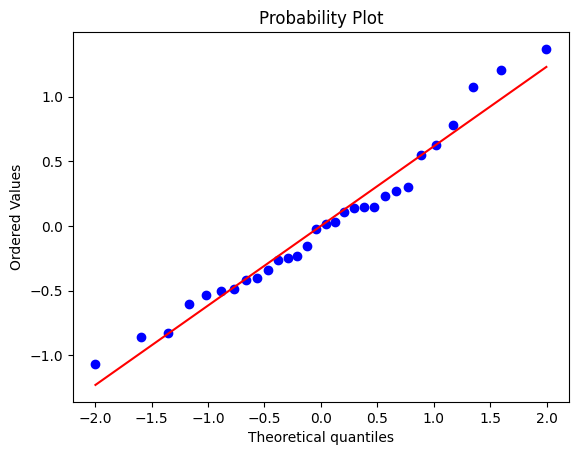

In [13]:
# Check the normality assumption
import scipy.stats as stats
residuals = model.resid # Extract the residuals
stats.probplot(residuals, plot=plt) # Create a normal probability plot

# Perform Shapiro-Wilk test for normality
stat, pval = stats.shapiro(residuals)
print(f"Shapiro-Wilk test: W = {stat}, p = {pval}")

# Perform Kruskal-Wallis test as non-parametric alternative
stat, pval = stats.kruskal(my_data[my_data['group'] == 'A']['weight'],
                           my_data[my_data['group'] == 'B']['weight'],
                           my_data[my_data['group'] == 'C']['weight'])
print(f"Kruskal-Wallis test: H = {stat}, p = {pval}")